Load in the weather, smartmeter and gasmeter data as 3 seperate dataframes. 
Goal is to combine them into one dataframe.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def load_data():
    global smart
    global gas
    global weather
    df =pd.read_csv("/datc/opschaler/smartmeter_data/P01S01W0373.csv",header=0,delimiter=";",parse_dates=['Timestamp', 'gasTimestamp'])

    # Split the smartmeter and gasmeter data
    smart = df.iloc[:,:7]
    gas = df.iloc[:, 7:]
    
    #Read in weather data
    weather_path = "//datc//opschaler//weather_data//20170101to20180101.txt"
    weather_column_names = ['STN','YYYYMMDD','HH','DD','FH','FF','FX','T','T10','TD','SQ','Q','DR','RH','P','VV','N','U','WW','IX','M','R','S','O','Y']

    weather = pd.read_csv(weather_path, delimiter=',', comment='#', names=weather_column_names, parse_dates=['YYYYMMDD', 'HH'])
    weather['T'] = weather['T']*0.01 # Convert temperature to celcius instead of 0.1 celcius
    weather['HH'] = weather['HH']+':00:00'
    weather['HH'] = weather['HH'].str.strip() # removes the blank spaces infront of the strings
    weather['HH'] = weather['HH'].str.replace('24:00:00', '23:59:59') # KNMI uses 24 for 00 hours.... to have to convert this for to_datetime to be able to work
    weather.loc[:,'datetime'] = pd.to_datetime(weather['YYYYMMDD'].astype(str)+' '+weather['HH'].astype(str)) #create datetime column

In [85]:
"""
Problem: How to merge 3 frames with 3 different datetime's?
The format is the same, but they don't have ''exact'' matches with each other. 
i.e. 

"""
load_data()
# Change all datetime columns to the same column name
smart = smart.rename(index=str, columns={"Timestamp":"datetime"})
gas = gas.rename(index=str, columns={"gasTimestamp":"datetime"})


"""
Only keep relevant information for scrumwise sprint 2.
-> smartmeter energy usage data
-> gasmeter gas usage data
-> outside temperature
-> global radiation
"""

#df = df[['datetime', 'eMeter', 'eMeterLow', 'ePower', 'gasMeter', 'T', 'Q']]
#df = df[['datetime', 'eMeter', 'eMeterLow', 'ePower', 'gasMeter']]
smart.head()

del weather['STN'], weather['HH'], weather['YYYYMMDD']

# Set datetime as index
weather = weather.set_index(['datetime'])
smart = smart.set_index(['datetime'])
gas = gas.set_index(['datetime'])

In [86]:
gas.head()

,gasMeter
datetime,
2017-03-07 18:00:00,1599.792
2017-03-07 18:00:00,1599.792
2017-03-07 18:00:00,1599.792
2017-03-07 18:00:00,1599.792
2017-03-07 18:00:00,1599.792


In [88]:
"""
Resample the dataframes to 10s intervals.
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html

"""
weather = weather.resample('10s').pad()
smart = smart.resample('10s').mean()
#gas = gas.resample('10s').pad() #Can't get this to work yet
gas.head()

,gasMeter
datetime,
2017-03-07 18:00:00,1599.792
2017-03-07 18:00:00,1599.792
2017-03-07 18:00:00,1599.792
2017-03-07 18:00:00,1599.792
2017-03-07 18:00:00,1599.792


In [92]:
df = pd.merge(smart, weather,left_index=True, right_index=True)
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,DD,FH,FF,FX,...,VV,N,U,WW,IX,M,R,S,O,Y
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 18:14:20,3717.472,0.0,3883.382,0.0,376.0,0.0,260,30,30,60,...,67,8,82,,5,0,0,0,0,0
2017-03-07 18:14:30,3717.473,0.0,3883.382,0.0,381.0,0.0,260,30,30,60,...,67,8,82,,5,0,0,0,0,0
2017-03-07 18:14:40,3717.474,0.0,3883.382,0.0,378.0,0.0,260,30,30,60,...,67,8,82,,5,0,0,0,0,0
2017-03-07 18:14:50,3717.475,0.0,3883.382,0.0,376.0,0.0,260,30,30,60,...,67,8,82,,5,0,0,0,0,0
2017-03-07 18:15:00,3717.476,0.0,3883.382,0.0,380.0,0.0,260,30,30,60,...,67,8,82,,5,0,0,0,0,0


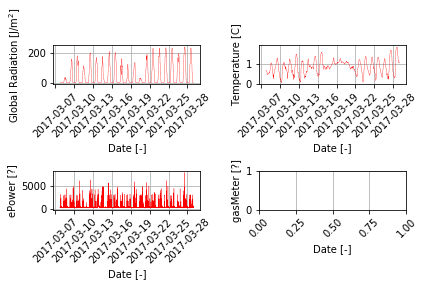

In [97]:
plt.subplot(2,2,1)
plt.plot(df.index, df['Q'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('Global Radiation [J/m$^2$]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,2)
plt.plot(df.index, df['T'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('Temperature [C]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(df.index, df['ePower'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('ePower [?]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.subplot(2,2,4)
#plt.plot(df.index, df['gasMeter'], '-', color='r', linewidth=1)
plt.xlabel('Date [-]')
plt.ylabel('gasMeter [?]')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

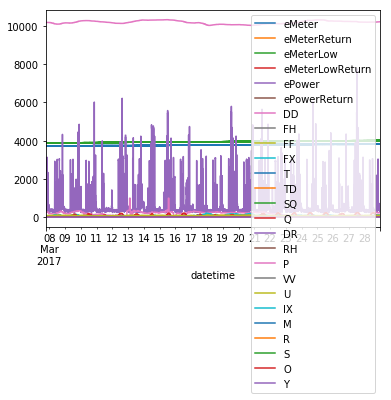

In [98]:
df.plot()

In [ ]:
_ = pd.plotting.scatter_matrix(df)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


In [5]:
df.shape

(627617, 7)

In [11]:
df.to_csv('//datc//opschaler//output//test.csv', sep='\t', index=False)

In [14]:
print('test')

test
